*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


In [ ]:
# import libraries

import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.7.0


In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2022-01-26 17:07:16--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.005s  

2022-01-26 17:07:16 (67.8 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2022-01-26 17:07:17--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

## Preprocess SMS
- Remove puntuation
- Lemmatize words
- Remove stopwords
- Transform to lowercase

In [ ]:
import re
import nltk
from nltk.stem.snowball import SnowballStemmer 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence



nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
df_train = pd.read_csv(train_file_path, header=None, names=['label', 'SMS'], sep='\t')
df_test = pd.read_csv(test_file_path, header=None, names=['label', 'SMS'], sep='\t')


In [ ]:
y_train = df_train.pop('label')
y_train = y_train.str.contains('spam').astype(np.int8).to_numpy()
y_test = df_test.pop('label')
y_test = y_test.str.contains('spam').astype(np.int8).to_numpy()

In [ ]:
train_sms = df_train['SMS']
test_sms = df_test['SMS']

In [ ]:
sw = stopwords.words("english")
lemmatizer = WordNetLemmatizer()
def clean_sms(sms):
  sms = re.sub(r'([^\s\w])+', ' ', sms)
  sms = ' '.join([lemmatizer.lemmatize(w) for w in sms.split() if w not in sw])
  sms = sms.lower()
  return sms 

In [ ]:
train_sms_clean = train_sms.apply(clean_sms)
test_sms_clean = test_sms.apply(clean_sms)

## Tokenize SMS

In [ ]:
# Keep top 1000 frequently occurring words
MAX_WORDS = 1500

# Cut off the words after seeing 500 words in each document
MAX_LEN = 200

In [ ]:
t = Tokenizer(num_words=MAX_WORDS)
t.fit_on_texts(train_sms_clean)

In [ ]:
train_seq = t.texts_to_sequences(train_sms_clean)
test_seq = t.texts_to_sequences(test_sms_clean)

In [ ]:
train_seq_mat = sequence.pad_sequences(train_seq, maxlen=MAX_LEN)
test_seq_mat = sequence.pad_sequences(test_seq, maxlen=MAX_LEN)


## LSTM Model Creation

In [ ]:
i = tf.keras.layers.Input(shape=[MAX_LEN])
x = tf.keras.layers.Embedding(MAX_WORDS, 50, input_length=MAX_LEN)(i)
x = tf.keras.layers.LSTM(50)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=i, outputs=x)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 200)]             0         
                                                                 
 embedding_24 (Embedding)    (None, 200, 50)           75000     
                                                                 
 lstm_41 (LSTM)              (None, 50)                20200     
                                                                 
 dense_46 (Dense)            (None, 256)               13056     
                                                                 
 dropout_37 (Dropout)        (None, 256)               0         
                                                                 
 dense_47 (Dense)            (None, 1)                 257       
                                                                 
Total params: 108,513
Trainable params: 108,513
Non-traina

In [ ]:
r = model.fit(train_seq_mat, y_train, batch_size=128, epochs=5, validation_split=0.2)

Epoch 1/5
23/23 [==============================] - 8s 248ms/step - loss: 0.5020 - accuracy: 0.8598 - val_loss: 0.3381 - val_accuracy: 0.8517
Epoch 2/5
23/23 [==============================] - 5s 223ms/step - loss: 0.2506 - accuracy: 0.8783 - val_loss: 0.1841 - val_accuracy: 0.9330
Epoch 3/5
23/23 [==============================] - 5s 224ms/step - loss: 0.1111 - accuracy: 0.9754 - val_loss: 0.0710 - val_accuracy: 0.9841
Epoch 4/5
23/23 [==============================] - 6s 284ms/step - loss: 0.0396 - accuracy: 0.9887 - val_loss: 0.0539 - val_accuracy: 0.9856
Epoch 5/5
23/23 [==============================] - 5s 221ms/step - loss: 0.0227 - accuracy: 0.9945 - val_loss: 0.0544 - val_accuracy: 0.9872


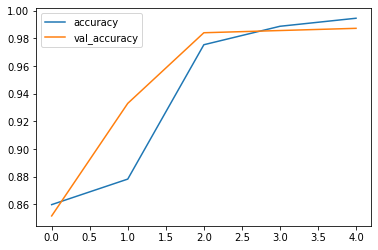

In [ ]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  clean_text = clean_sms(pred_text)
  tokens = t.texts_to_sequences([pred_text])
  y_pred = model.predict(tokens)

  return y_pred[0][0], 'ham' if y_pred[0][0] < 0.5 else 'spam' 

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

(0.2156075, 'ham')


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    print(prediction)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


(0.2156075, 'ham')
(0.8564458, 'spam')
(0.003940046, 'ham')
(0.9474017, 'spam')
(0.98861563, 'spam')
(0.08831918, 'ham')
(0.011830151, 'ham')
You passed the challenge. Great job!
